In [1]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
from pymongo import MongoClient

In [2]:
def _connect_mongo(host, port, username, password, db):
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    cursor = db[collection].find(query)
    
    comments = [j['text'].lower() for i in list(cursor) for j in i['posts']]
    return comments

In [3]:
comments = read_mongo('CryptoDB', 'coments')

In [40]:
def clean_comments(text):
    letters_only = re.sub('[^a-z]', ' ', text)
    words = letters_only.lower().split()
    stopwords_eng = set(stopwords.words("english"))
    useful_words = [x for x in words if not x in stopwords_eng and len(x) <=20]
    
    useful_words_string = ' '.join(useful_words)
    return(useful_words_string)

text_list_clean = list(map(clean_comments, comments))

In [41]:
stemmer = PorterStemmer()

def stem_words(words_list, stemmer):
    return [stemmer.stem(word) for word in words_list]

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_words(tokens, stemmer)
    return stems

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(text_list_clean)

In [42]:
tfs.shape

(102, 1752)

In [60]:
k = 7
km = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=5)
km.fit(tfs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=7, n_init=5, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

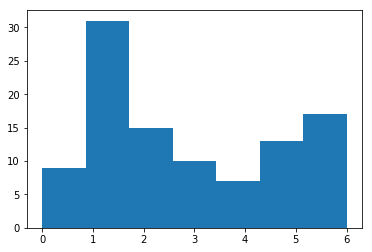

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(km.labels_, bins=k)
plt.show()

In [62]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [64]:
k = 7
tfs_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(tfs)

In [65]:
tfs_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(tfs_reduced)

[t-SNE] Computing 101 nearest neighbors...
[t-SNE] Indexed 102 samples in 0.000s...
[t-SNE] Computed neighbors for 102 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 102 / 102
[t-SNE] Mean sigma: 0.215474
[t-SNE] Computed conditional probabilities in 0.007s
[t-SNE] Iteration 50: error = 50.8875618, gradient norm = 0.5986756 (50 iterations in 0.093s)
[t-SNE] Iteration 100: error = 50.2801018, gradient norm = 0.5951191 (50 iterations in 0.070s)
[t-SNE] Iteration 150: error = 51.5087852, gradient norm = 0.5788080 (50 iterations in 0.071s)
[t-SNE] Iteration 200: error = 53.3617401, gradient norm = 0.5279607 (50 iterations in 0.074s)
[t-SNE] Iteration 250: error = 51.8004189, gradient norm = 0.5427606 (50 iterations in 0.069s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.800419
[t-SNE] Iteration 300: error = 0.6526135, gradient norm = 0.0109175 (50 iterations in 0.071s)
[t-SNE] Iteration 350: error = 0.2189324, gradient norm = 0.0052369 

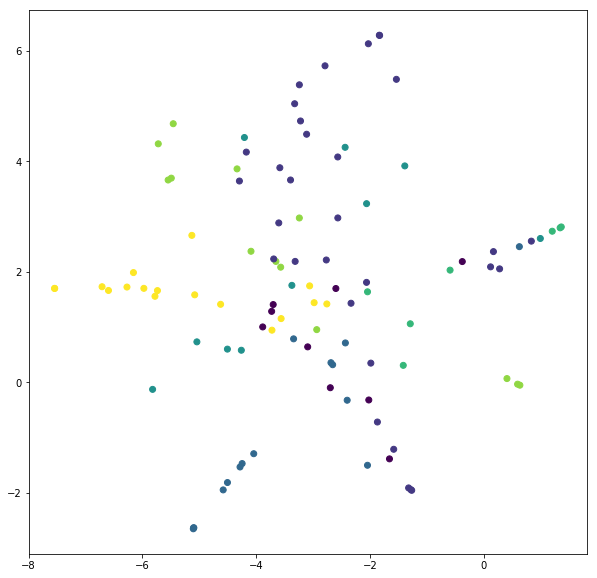

In [66]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], c = km.labels_)
plt.show()

In [67]:
for k in range (1, 20):
    kmeans_model = KMeans(n_clusters=k).fit(tfs)
    labels = kmeans_model.labels_
    interia = kmeans_model.inertia_
    print("k:",k, " cost:", interia)

k: 1  cost: 97.8942907653297
k: 2  cost: 95.19603335337636
k: 3  cost: 93.40764546916033
k: 4  cost: 91.88368737954477
k: 5  cost: 90.41693036027863
k: 6  cost: 88.31002228198342
k: 7  cost: 86.60054453421013
k: 8  cost: 84.51160517617653
k: 9  cost: 82.74932279359672
k: 10  cost: 81.55637939345944
k: 11  cost: 80.10170169636247
k: 12  cost: 78.77060629574973
k: 13  cost: 77.22449879187913
k: 14  cost: 75.48714077647337
k: 15  cost: 74.34687351052335
k: 16  cost: 72.82493350121833
k: 17  cost: 71.28211936326015
k: 18  cost: 70.67970138982119
k: 19  cost: 68.15765602216689
